# SWOP script 4
## Compute mean amplitude measurements and export for analysis in R

Analysis script associated with the manuscript: ***Native word order processing is not uniform: An ERP-study of verb-second word order***, by Susan Sayehli, Marianne Gullberg, Aaron Newman, and Annika Andersson. (2022). *Frontiers in Psychology - Language Sciences*. DOI:[10.3389/fpsyg.2022.668276](https://www.frontiersin.org/articles/10.3389/fpsyg.2022.668276).

This notebook reads in the *-epo.fif evoked files from individual subjects that were produced by the batch individual subject preprocessing in the script *SWOP 1 - preprocessing.py*

This script does not compute or apply baseline regression to the data. Rather, it computes mean amplitudes in specified time windows, including the prestimulus baseline period (-100-0 ms). Then, the baseline mean amplitude is added as a column/variable for each subject/trial/electrode, so that baseline can be used as a variable in mixed-effects analysis.

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [The 3-Clause BSD License](https://opensource.org/licenses/BSD-3-Clause)

---

## Load in the necessary libraries/packages we'll need

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
from scipy.stats import zscore
import matplotlib.pyplot as plt
import mne
mne.set_log_level(verbose='error')

## List of subjects

In [2]:
subjects = ['s_04nm',  's_07ba',  's_09lo',  's_12wg',  's_13ff',  's_14mc',
            's_15rj',  's_17oh',  's_18ak',  's_19am',  's_21ma',  's_23nj',
            's_24zk',  's_25ks',  's_26nm',  's_27lm',  's_28js',  's_29ld',
            's_30la',  's_31bf']

## Time windows of interest

In [3]:
# Define the traditional baseline window
baseline = (-.100, 0.)
tmin, tmax = -.100, 1.
# Define start & end of time window to compute MeanAmplitude over
time_wins = [(.100, .300), (.300, .500), (.500, .700), (.700, .900), (.900, 1.000)]

## Conditions and Contrasts of Interest

In [4]:
target_words = ['kanske', 'hemma', 'idag']

conditions = ['V2/kanske', 'V3/kanske', 
              'V2/hemma',  'V3/hemma',
              'V2/idag',   'V3/idag'
             ]

contrasts = {'kanske':['V3/kanske', 'V2/kanske'],
             'hemma':['V3/hemma',   'V2/hemma'],
             'idag':['V3/idag',     'V2/idag'],             
             }

## Time windows

In [5]:
components = {'baseline':{'tw':(-.100, 0.), 'tw_width':.100},
              '100-300':{'tw':(.100, .300), 'tw_width':.200},
              '300-500':{'tw':(.300, .500), 'tw_width':.200},
              '500-700':{'tw':(.500, .700), 'tw_width':.200},
              '700-900':{'tw':(.700, .900), 'tw_width':.200},
              '900-1000':{'tw':(.900, 1.), 'tw_width':.100},
              }

## Define ROIs
clusters of electrodes to average over for waveform plots

In [6]:
rois = {'L_Ant':['F7', 'FT7', 'F3', 'FC3'],
        'M_Ant':['Fz'],
        'R_Ant':['F8', 'FT8', 'F4', 'FC4'],
        'L_Cent':['T7', 'TP7', 'C3', 'CP3'], 
        'M_Cent':['Cz'], 
        'R_Cent':['T8', 'TP8', 'C4', 'CP4'],
        'L_Post':['P7', 'P3', 'PO7', 'O1'],
        'M_Post':['Pz'],
        'R_Post':['P8', 'P4', 'PO8', 'O2'],
        'Other':['Fp1', 'Fp2', 'M1', 'M2']
       }

roi_order = ['L_Ant', 'M_Ant', 'R_Ant',
             'L_Cent', 'M_Cent', 'R_Cent',
             'L_Post', 'M_Post', 'R_Post'
            ]

ch_roi_map = {}
for roi, chans in rois.items():
    for chan in chans:
        ch_roi_map[chan] = roi

# We don't need Other anymore
rois.pop('Other');   

---
## Read in the data

In [7]:
data_path = '../data/'

epochs = {}
for subject in subjects:
    epochs[subject] = mne.read_epochs(str(data_path + subject + '-epo.fif'),
                                         proj=False, 
                                         verbose=None, 
                                         preload=True).set_eeg_reference(ref_channels=['M1', 'M2'])

---
## Compute single-trial measurements

In [8]:
%%time

df_list = []
metadata_cols = ['Sentence', 'postphrase', 'pronoun_noun', 'questiondisplay.ACC', 
                 'questiondisplay.RT', 'sentence_no', 'stimulussentence']


for subj in subjects:
    for cond in conditions:
        for roi, chans in rois.items():
            for comp_name, comp_params in components.items():

                win_start, win_stop = np.searchsorted(epochs[subj][cond].times, comp_params['tw'])

                df_list.append(pd.concat([pd.DataFrame({'Subject': subj, 
                                                        'Component':comp_name,
                                                        'Trial Time':np.repeat(epochs[subj][cond].events[:,0], len(chans)),
                                                        'Condition':cond,
                                                        'ROI':roi,
                                                        'Channel':np.tile(chans, epochs[subj][cond].selection.shape),
                                                        }),
                                            pd.DataFrame(epochs[subj][cond].get_data(picks=chans)[:, :, win_start:win_stop].mean(axis=-1).flatten() * 10e5,
                                                         columns=['MeanAmpl']), 
                                            pd.DataFrame(np.repeat(np.array(epochs[subj][cond].metadata[metadata_cols]).byteswap().newbyteorder(), len(chans), axis=0), 
                                                         columns=metadata_cols),
                                             ], 
                                             axis=1))

df = pd.concat(df_list)
df[['SentPos', 'Adverb']] = df['Condition'].str.split('/', expand=True)
df[['Laterality', 'AntPost']] = df['ROI'].str.split('_', expand=True)

CPU times: user 33 s, sys: 95.9 ms, total: 33.1 s
Wall time: 33.1 s


## Plot histogram
look for outliers

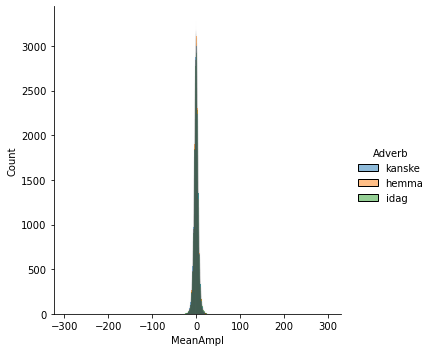

In [9]:
sns.displot(data=df,
            x='MeanAmpl', hue='Adverb')
plt.show()

## Remove Outliers

Defined within-subjects, as data points (individual trials/channels) with abs(*z*) > 2.5 

In [10]:
z_thresh = 2.5 # cutoff for defining outliers, in SD

# Compute standard (z) scores 
df['MeanAmpl z'] = df.loc[:, ['Subject', 
                               'MeanAmpl']].groupby('Subject').transform(zscore)

len_orig = len(df)

# Drop outliers based on ±2.5 SD
df = df[(df['MeanAmpl z'] >= -z_thresh) & (df['MeanAmpl z'] <= z_thresh)]

n_dropped = len_orig - len(df)
print(str(round(((n_dropped / len_orig) * 100), 3)) + '% of data dropped as outliers based MeanAmplitude z +/-' + str(z_thresh))

1.97% of data dropped as outliers based MeanAmplitude z +/-2.5


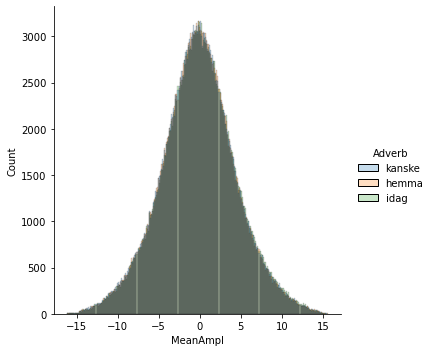

In [11]:
sns.displot(data=df,
            x='MeanAmpl', hue='Adverb', alpha=.25)
plt.show()

In [12]:
df.sample(12)

,Subject,Component,Trial Time,Condition,ROI,Channel,MeanAmpl,Sentence,postphrase,pronoun_noun,questiondisplay.ACC,questiondisplay.RT,sentence_no,stimulussentence,SentPos,Adverb,Laterality,AntPost,MeanAmpl z
4,s_27lm,300-500,75793,V2/hemma,L_Cent,T7,-3.162032,17,0.0,N,1,1001,24.0,Hemma skrattade pojken.,V2,hemma,L,Cent,-0.588709
0,s_19am,700-900,54049,V3/kanske,L_Post,P7,-2.890189,14,3.0,N,1,1922,8.0,Kanske flickan handlade en ny mössa.,V3,kanske,L,Post,-0.543762
129,s_23nj,300-500,2000762,V3/hemma,L_Cent,TP7,0.664302,410,0.0,P,1,321,37.0,Hemma han vaknade.,V3,hemma,L,Cent,0.294444
122,s_18ak,900-1000,1801274,V3/kanske,L_Cent,C3,-6.767970,301,2.0,N,0,674,26.0,Kanske flickan smakade Annas kakor.,V3,kanske,L,Cent,-1.739694
148,s_18ak,baseline,2442400,V3/idag,R_Ant,F8,-3.036924,455,0.0,N,1,519,35.0,Idag pojken tvättade.,V3,idag,R,Ant,-0.736331
4,s_09lo,100-300,84568,V2/kanske,R_Post,P8,1.237251,18,5.0,N,1,161,19.0,Kanske pratade pojken med Maria hemma i köket.,V2,kanske,R,Post,0.272520
94,s_17oh,100-300,909045,V3/kanske,L_Post,PO7,10.851792,237,1.0,P,0,430,11.0,Kanske hon joggade hem.,V3,kanske,L,Post,1.801610
25,s_31bf,500-700,1356803,V2/hemma,M_Post,Pz,0.630128,333,1.0,N,1,294,10.0,Hemma jobbade pojken gärna.,V2,hemma,M,Post,0.184836
17,s_24zk,100-300,270146,V2/idag,L_Ant,FT7,2.591044,57,4.0,N,1,267,33.0,Idag talade flickan med Eva och Maria.,V2,idag,L,Ant,0.659426
17,s_14mc,100-300,139317,V3/kanske,L_Ant,FT7,-1.733911,49,1.0,P,1,248,5.0,Kanske hon dansade gärna.,V3,kanske,L,Ant,-0.231470


In [13]:
df.shape

(761961, 19)

## Make baseline a variable

Pivote 'Component' and then melt back to a Component column without baseline. `baseline` is now its own column

In [14]:
df = df.pivot(index=['Subject', 'Trial Time', 'Condition', 'ROI', 'Channel', 
                        'Sentence', 'postphrase', 'pronoun_noun', 
                        'questiondisplay.ACC', 'questiondisplay.RT', 
                        'sentence_no', 'stimulussentence', 
                        'SentPos', 'Adverb', 'Laterality', 'AntPost', 
                        ], 
                 columns='Component', 
                 values='MeanAmpl'
                )

In [15]:
df = df.reset_index().melt(id_vars=['Subject', 'Trial Time', 'Condition', 'ROI', 'Channel', 
                                            'Sentence', 'postphrase', 'pronoun_noun', 
                                            'questiondisplay.ACC', 'questiondisplay.RT', 
                                            'sentence_no', 'stimulussentence', 
                                            'SentPos', 'Adverb', 'Laterality', 'AntPost', 'baseline'
                                            ],
                                value_vars=['100-300', '300-500', '500-700', '700-900', '900-1000'],
                              ignore_index=False,
                                   value_name='MeanAmpl'
                                  )

In [16]:
df.shape

(647675, 19)

## Confirm this worked
For a given subject/trial/electrode, the value in `baseline` should appear for every component time window.

In [17]:
df[(df['Subject']=='s_18ak') & (df['Trial Time']==47855) & (df['Channel']=='Cz')]

,Subject,Trial Time,Condition,ROI,Channel,Sentence,postphrase,pronoun_noun,questiondisplay.ACC,questiondisplay.RT,sentence_no,stimulussentence,SentPos,Adverb,Laterality,AntPost,baseline,Component,MeanAmpl
51823,s_18ak,47855,V2/hemma,M_Cent,Cz,5,3.0,N,1,1092,22.0,Hemma satt flickan vid sin bänk.,V2,hemma,M,Cent,-2.085592,100-300,-5.228227
51823,s_18ak,47855,V2/hemma,M_Cent,Cz,5,3.0,N,1,1092,22.0,Hemma satt flickan vid sin bänk.,V2,hemma,M,Cent,-2.085592,300-500,1.444598
51823,s_18ak,47855,V2/hemma,M_Cent,Cz,5,3.0,N,1,1092,22.0,Hemma satt flickan vid sin bänk.,V2,hemma,M,Cent,-2.085592,500-700,4.815046
51823,s_18ak,47855,V2/hemma,M_Cent,Cz,5,3.0,N,1,1092,22.0,Hemma satt flickan vid sin bänk.,V2,hemma,M,Cent,-2.085592,700-900,8.350493
51823,s_18ak,47855,V2/hemma,M_Cent,Cz,5,3.0,N,1,1092,22.0,Hemma satt flickan vid sin bänk.,V2,hemma,M,Cent,-2.085592,900-1000,2.655623


In [18]:
df[(df['Subject']=='s_18ak') & (df['Trial Time']==1021477) & (df['Channel']=='Cz')]

,Subject,Trial Time,Condition,ROI,Channel,Sentence,postphrase,pronoun_noun,questiondisplay.ACC,questiondisplay.RT,sentence_no,stimulussentence,SentPos,Adverb,Laterality,AntPost,baseline,Component,MeanAmpl
54140,s_18ak,1021477,V2/kanske,M_Cent,Cz,178,0.0,N,0,3559,36.0,Kanske tystnade flickan.,V2,kanske,M,Cent,-2.418007,100-300,7.824811
54140,s_18ak,1021477,V2/kanske,M_Cent,Cz,178,0.0,N,0,3559,36.0,Kanske tystnade flickan.,V2,kanske,M,Cent,-2.418007,300-500,6.709755
54140,s_18ak,1021477,V2/kanske,M_Cent,Cz,178,0.0,N,0,3559,36.0,Kanske tystnade flickan.,V2,kanske,M,Cent,-2.418007,500-700,1.452083
54140,s_18ak,1021477,V2/kanske,M_Cent,Cz,178,0.0,N,0,3559,36.0,Kanske tystnade flickan.,V2,kanske,M,Cent,-2.418007,700-900,-5.208982
54140,s_18ak,1021477,V2/kanske,M_Cent,Cz,178,0.0,N,0,3559,36.0,Kanske tystnade flickan.,V2,kanske,M,Cent,-2.418007,900-1000,-2.284054


## Export to file

In [19]:
df.to_csv('../group_data/SWOP_ERP_measurements.csv', index=False)